# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench import Samplers
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol


In [3]:
def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25,
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))

    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt

    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

#### 1. Sensitivity analysis
Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

In [4]:
from ema_workbench import RealParameter, Model
from ema_workbench.em_framework.samplers import LHSSampler, sample_uncertainties
import pandas as pd

# Define your model
model = Model('predprey', function=pred_prey)
model.uncertainties = [
    RealParameter('prey_birth_rate', 0.015, 0.035),
    RealParameter('predation_rate', 0.0005, 0.003),
    RealParameter('predator_efficiency', 0.001, 0.004),
    RealParameter('predator_loss_rate', 0.04, 0.08),
]

# Sample scenarios from model uncertainties
scenarios = list(sample_uncertainties(models=[model], n_samples=100, sampler=LHSSampler()))
samples_df = pd.DataFrame.from_records(scenarios)
print(samples_df.head())

   predation_rate  predator_efficiency  predator_loss_rate  prey_birth_rate
0        0.002137             0.002381            0.042563         0.030916
1        0.002792             0.001040            0.051377         0.021712
2        0.001654             0.003221            0.076470         0.015020
3        0.001415             0.001297            0.063982         0.029352
4        0.001013             0.001807            0.053877         0.016845


In [5]:
model.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]
from ema_workbench import SequentialEvaluator, MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress
from ema_workbench.em_framework.evaluators import Samplers


# with MultiprocessingEvaluator(model) as evaluator:
#     experimenents, outcomes = evaluator.perform_experiments(n_scenarios, n_policies, lever_sampling=Samplers.MC)
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios)




100%|███████████████████████████████████████| 100/100 [00:00<00:00, 478.32it/s]


In [6]:
experiments

,prey_birth_rate,predation_rate,predator_efficiency,predator_loss_rate,scenario,policy,model
0,0.030916,0.002137,0.002381,0.042563,0,None,predprey
1,0.021712,0.002792,0.001040,0.051377,1,None,predprey
2,0.015020,0.001654,0.003221,0.076470,2,None,predprey
3,0.029352,0.001415,0.001297,0.063982,3,None,predprey
4,0.016845,0.001013,0.001807,0.053877,4,None,predprey
...,...,...,...,...,...,...,...
95,0.019929,0.002011,0.002795,0.076062,95,None,predprey
96,0.034013,0.000880,0.001086,0.049358,96,None,predprey
97,0.032072,0.002473,0.002332,0.052730,97,None,predprey
98,0.018153,0.002116,0.001372,0.040343,98,None,predprey


In [7]:
# Extract outputs
y = outcomes['prey'].squeeze()  # Now shape is (100, 1461)
X = sm.add_constant(experiments[['prey_birth_rate', 'predation_rate', 'predator_efficiency', 'predator_loss_rate']])

# Run OLS for each target
results = {}
targets = {
    'Final Prey': y[:, -1],          # final time step
    'Mean Prey': y.mean(axis=1),     # average over time
    'Std Prey': y.std(axis=1),       # std dev over time
}
print(y.shape)
for label, y in targets.items():
    model_ols = sm.OLS(y, X).fit()
    results[label] = model_ols.summary()

# Print one example
print(results['Final Prey'])

(100, 1461)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     10.90
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.59e-07
Time:                        16:55:25   Log-Likelihood:                -419.23
No. Observations:                 100   AIC:                             848.5
Df Residuals:                      95   BIC:                             861.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 

#### 2. SOBOL
Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply use slicing to get the results for N=50 and N=250.

In [8]:
from SALib.analyze import sobol
n_scenarios = 256

with SequentialEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(
            n_scenarios, uncertainty_sampling=Samplers.SOBOL
        )
problem = get_SALib_problem(model.uncertainties)
y = outcomes['prey'][:, 0, -1]  # shape becomes (100,)
y.shape
sobol_indices = sobol.analyze(problem, y)
sobol_stats = {key: sobol_indices[key] for key in ["ST", "ST_conf", "S1", "S1_conf"]}
sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])
sobol_stats.sort_values(by="ST", ascending=False)
s2 = pd.DataFrame(sobol_indices["S2"], index=problem["names"], columns=problem["names"])
s2_conf = pd.DataFrame(
    sobol_indices["S2_conf"], index=problem["names"], columns=problem["names"]
)
print(sobol_stats)
print(s2)
print(s2_conf)

100%|█████████████████████████████████████| 2560/2560 [00:05<00:00, 475.15it/s]

                           ST   ST_conf        S1   S1_conf
predation_rate       1.508578  2.161720 -0.044127  1.136830
predator_efficiency  0.513688  0.471962  0.210627  0.868058
predator_loss_rate   0.607102  0.513841 -0.092848  0.880511
prey_birth_rate      1.312184  1.260193 -0.204415  1.444668
                     predation_rate  predator_efficiency  predator_loss_rate  \
predation_rate                  NaN            -0.215927            0.401495   
predator_efficiency             NaN                  NaN            0.766729   
predator_loss_rate              NaN                  NaN                 NaN   
prey_birth_rate                 NaN                  NaN                 NaN   

                     prey_birth_rate  
predation_rate              1.120229  
predator_efficiency         0.861734  
predator_loss_rate          0.247553  
prey_birth_rate                  NaN  
                     predation_rate  predator_efficiency  predator_loss_rate  \
predation_rate          


c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


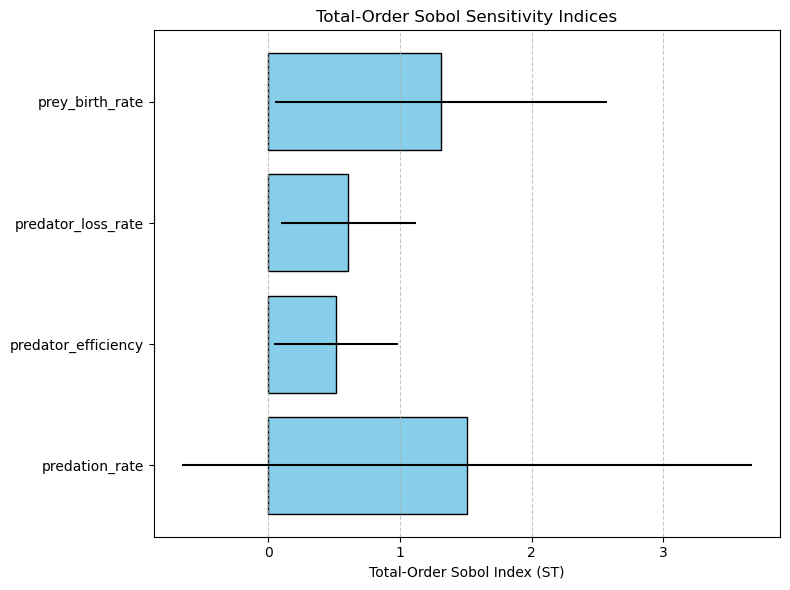

In [10]:
# Extract parameter names and corresponding ST values and confidence intervals
parameters = sobol_stats.index.tolist()
ST_values = sobol_stats['ST'].values
ST_conf = sobol_stats['ST_conf'].values

# Create a horizontal bar chart
plt.figure(figsize=(8, 6))
bars = plt.barh(parameters, ST_values, xerr=ST_conf, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Total-Order Sobol Index (ST)')
plt.title('Total-Order Sobol Sensitivity Indices')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 3. Extra trees
Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)